In [1]:
#!/bin/bash
!curl -L -o daily-climate-time-series-data.zip https://www.kaggle.com/api/v1/datasets/download/sumanthvrao/daily-climate-time-series-data

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 22518  100 22518    0     0  44724      0 --:--:-- --:--:-- --:--:-- 44724


In [2]:
!unzip daily-climate-time-series-data.zip

Archive:  daily-climate-time-series-data.zip
replace DailyDelhiClimateTest.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: DailyDelhiClimateTest.csv  
replace DailyDelhiClimateTrain.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: DailyDelhiClimateTrain.csv  


In [3]:
# Установка необходимых библиотек
!pip install descartes matplotlib pandas statsmodels pmdarima

In [1]:
# Для обработки данных
import pandas as pd  # Основной инструмент для работы с данными в табличном формате
import numpy as np  # Библиотека для работы с массивами и математическими операциями

# Визуализация данных
import matplotlib.pyplot as plt  # Основной инструмент для создания графиков
import seaborn as sns  # Инструмент для более удобной визуализации данных, построенный на основе matplotlib
sns.set_style("darkgrid")  # Устанавливаем стиль визуализации
import plotly.express as px  # Интерактивная визуализация данных
from folium.plugins import HeatMap  # Плагин для отображения тепловых карт

# Статистический анализ и модели
from scipy import stats
from statsmodels.formula.api import ols
import statsmodels.api as sm  # Основной инструмент для статистического анализа и построения моделей
import statsmodels.formula.api as smf  # Форматирование статистических моделей
from statsmodels.stats.diagnostic import het_breuschpagan  # Тест на гетероскедастичность
from statsmodels.stats.multicomp import pairwise_tukeyhsd  # Тест Тьюки для множественных сравнений
from statsmodels.tsa.statespace.sarimax import SARIMAX  # Модель SARIMAX для временных рядов
from statsmodels.tsa.stattools import adfuller  # Тест Дики-Фуллера для проверки стационарности
from statsmodels.tsa.vector_ar.var_model import VAR  # Модель VAR для многомерных временных рядов
from pmdarima import auto_arima

# Моделирование и оценка качества
from sklearn.decomposition import PCA  # Метод главных компонент для уменьшения размерности
from sklearn.cluster import KMeans  # Алгоритм кластеризации K-средних
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score  # Метрики для оценки моделей

# Математические функции
import math  # Математические функции, такие как вычисление квадратных корней


import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.api import VAR
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from scipy.stats import jarque_bera


Data preprocessing

In [2]:
train = pd.read_csv('DailyDelhiClimateTrain.csv')
test = pd.read_csv('DailyDelhiClimateTest.csv')

In [3]:
# Вычисление Z-оценки['z_score'] = stats.zscore(df['price'])
train['z_score'] = stats.zscore(train['meanpressure'])
outliers_z = train[train['z_score'].abs() > 3]
print(outliers_z)

# Вычисление межквартильного размаха (IQR)
Q1 = train['meanpressure'].quantile(0.25)
Q3 = train['meanpressure'].quantile(0.75)
IQR = Q3 - Q1

outliers_iqr = train[(train['meanpressure'] < (Q1 - 1.5 * IQR)) | (train['meanpressure'] > (Q3 + 1.5 * IQR))]
print(outliers_iqr)

            date   meantemp   humidity  wind_speed  meanpressure    z_score
1182  2016-03-28  25.933333  52.800000    6.546667   7679.333333  37.010757
1309  2016-08-02  30.687500  72.125000    6.375000    310.437500  -3.888921
1323  2016-08-16  31.333333  66.416667   14.666667     -3.041667  -5.628829
1427  2016-11-28  22.454545  37.318182    9.185714     12.045455  -5.545091
            date   meantemp   humidity  wind_speed  meanpressure    z_score
1182  2016-03-28  25.933333  52.800000    6.546667   7679.333333  37.010757
1255  2016-06-09  35.733333  43.733333    9.260000    938.066667  -0.405383
1300  2016-07-24  31.437500  72.250000    2.431250    946.312500  -0.359616
1309  2016-08-02  30.687500  72.125000    6.375000    310.437500  -3.888921
1321  2016-08-14  28.933333  83.700000    6.370000    633.900000  -2.093603
1323  2016-08-16  31.333333  66.416667   14.666667     -3.041667  -5.628829
1362  2016-09-24  31.240000  66.480000    5.496154   1352.615385   1.895492
1416  2016-1

In [4]:
train_cleaned = train[~train.index.isin(outliers_iqr.index)]


# Удаление выбросов
train_cleaned = train[~train.index.isin(outliers_iqr.index)]

# Вычисление среднего значения столбца meanpressure для очищенных данных
mean_pressure_cleaned = train_cleaned['meanpressure'].mean()

# Замена выбросов на среднее значение
train.loc[outliers_iqr.index, 'meanpressure'] = mean_pressure_cleaned

# Проверка результата
print(train.head())

         date   meantemp   humidity  wind_speed  meanpressure   z_score
0  2013-01-01  10.000000  84.500000    0.000000   1015.666667  0.025321
1  2013-01-02   7.400000  92.000000    2.980000   1017.800000  0.037162
2  2013-01-03   7.166667  87.000000    4.633333   1018.666667  0.041972
3  2013-01-04   8.666667  71.333333    1.233333   1017.166667  0.033647
4  2013-01-05   6.000000  86.833333    3.700000   1016.500000  0.029946


In [69]:
test.head()

,date,meantemp,humidity,wind_speed,meanpressure
0,2017-01-01,15.913043,85.869565,2.743478,59.000000
1,2017-01-02,18.500000,77.222222,2.894444,1018.277778
2,2017-01-03,17.111111,81.888889,4.016667,1018.333333
3,2017-01-04,18.700000,70.050000,4.545000,1015.700000
4,2017-01-05,18.388889,74.944444,3.300000,1014.333333


In [5]:
print(len(train))
print(len(train_cleaned))

1462
1453


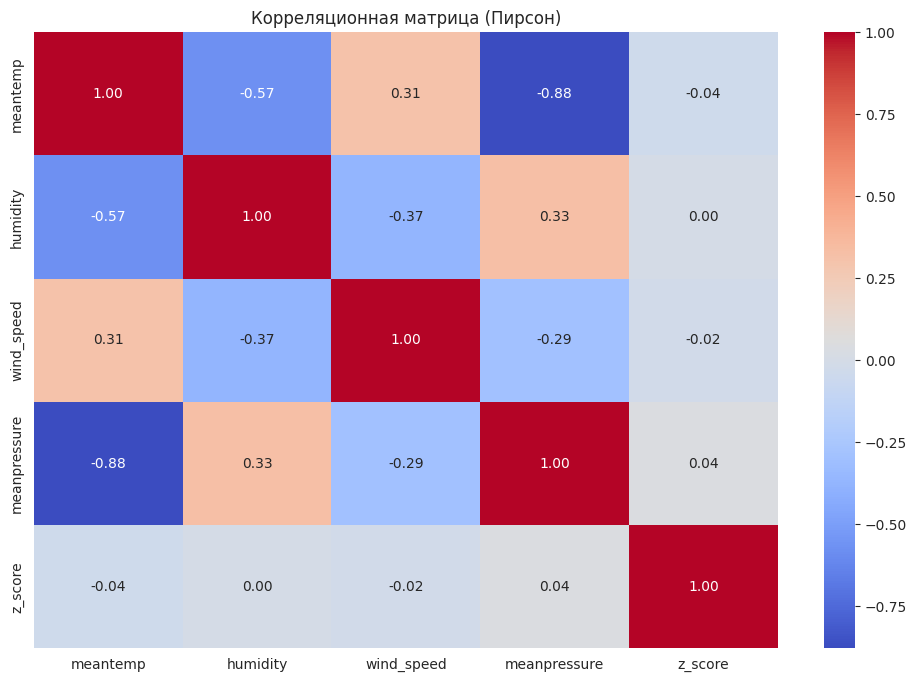

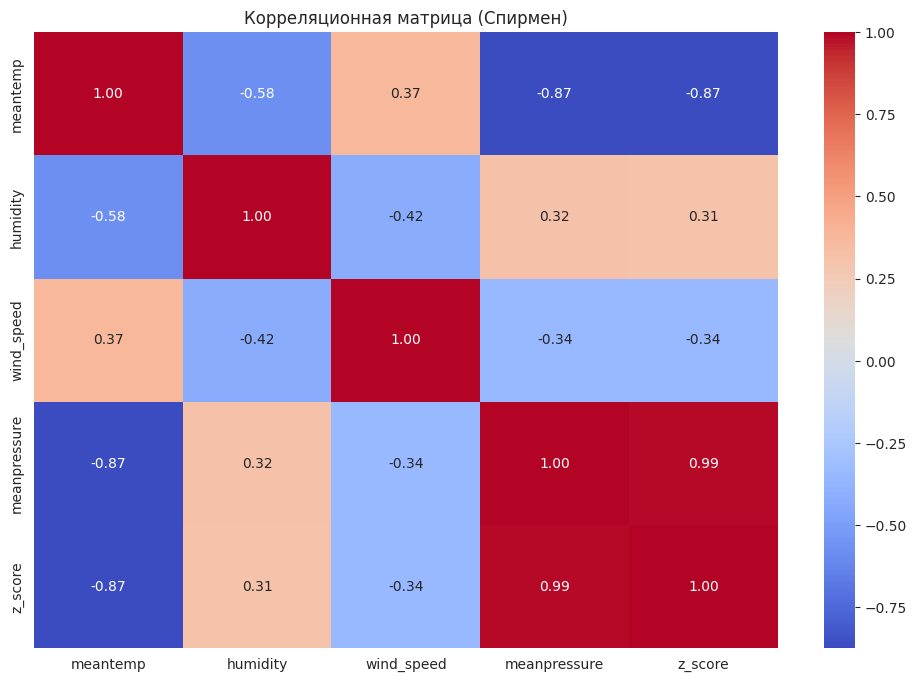

In [6]:
# Оставляем только числовые столбцы
numeric_df = train.select_dtypes(include=['float64', 'int64', 'int32'])

# Рассчитываем коэффициенты корреляции
pearson_corr = numeric_df.corr(method='pearson')
spearman_corr = numeric_df.corr(method='spearman')

# Визуализация
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
sns.heatmap(pearson_corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Корреляционная матрица (Пирсон)')
plt.show()

plt.figure(figsize=(12, 8))
sns.heatmap(spearman_corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Корреляционная матрица (Спирмен)')
plt.show()

In [7]:
train = train.drop('z_score', axis=1)
print(train.head())

         date   meantemp   humidity  wind_speed  meanpressure
0  2013-01-01  10.000000  84.500000    0.000000   1015.666667
1  2013-01-02   7.400000  92.000000    2.980000   1017.800000
2  2013-01-03   7.166667  87.000000    4.633333   1018.666667
3  2013-01-04   8.666667  71.333333    1.233333   1017.166667
4  2013-01-05   6.000000  86.833333    3.700000   1016.500000


In [8]:
print(test.head())

         date   meantemp   humidity  wind_speed  meanpressure
0  2017-01-01  15.913043  85.869565    2.743478     59.000000
1  2017-01-02  18.500000  77.222222    2.894444   1018.277778
2  2017-01-03  17.111111  81.888889    4.016667   1018.333333
3  2017-01-04  18.700000  70.050000    4.545000   1015.700000
4  2017-01-05  18.388889  74.944444    3.300000   1014.333333


In [32]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.api import VAR
from statsmodels.tsa.statespace.varmax import VARMAX
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
from scipy.stats import shapiro


# 1. Разделение данных на train/val/test
train_data, val_data = train_test_split(train, test_size=0.2, shuffle=False)
test_data = test  # Уже предоставленная тестовая выборка

# Разделение на X и y
# Для train и val
train_X = train_data[['meantemp', 'humidity', 'wind_speed', 'meanpressure']]
train_y = train_data['meantemp']  # Целевой столбец - meantemp

val_X = val_data[['meantemp', 'humidity', 'wind_speed', 'meanpressure']]
val_y = val_data['meantemp']  # Целевой столбец - meantemp

# Для test
test_X = test_data[['meantemp', 'humidity', 'wind_speed', 'meanpressure']]
test_y = test_data['meantemp']  # Целевой столбец - meantemp

# 2. Нормализация данных
scaler_X = StandardScaler()
scaler_y = StandardScaler()

# Нормализация X (признаки)
train_X_scaled = scaler_X.fit_transform(train_X)
val_X_scaled = scaler_X.transform(val_X)
test_X_scaled = scaler_X.transform(test_X)

# Нормализация y (целевой столбец)
train_y_scaled = scaler_y.fit_transform(train_y.values.reshape(-1, 1)).flatten()
val_y_scaled = scaler_y.transform(val_y.values.reshape(-1, 1)).flatten()
test_y_scaled = scaler_y.transform(test_y.values.reshape(-1, 1)).flatten()

# Преобразование в DataFrame
train_X_scaled = pd.DataFrame(train_X_scaled, columns=train_X.columns)
val_X_scaled = pd.DataFrame(val_X_scaled, columns=val_X.columns)
test_X_scaled = pd.DataFrame(test_X_scaled, columns=test_X.columns)

VAR

Оптимальное количество лагов: 27
Shapiro-Wilk test: p-value = 2.9389692833981635e-56
MAE на тестовой выборке: 5.780722115730471


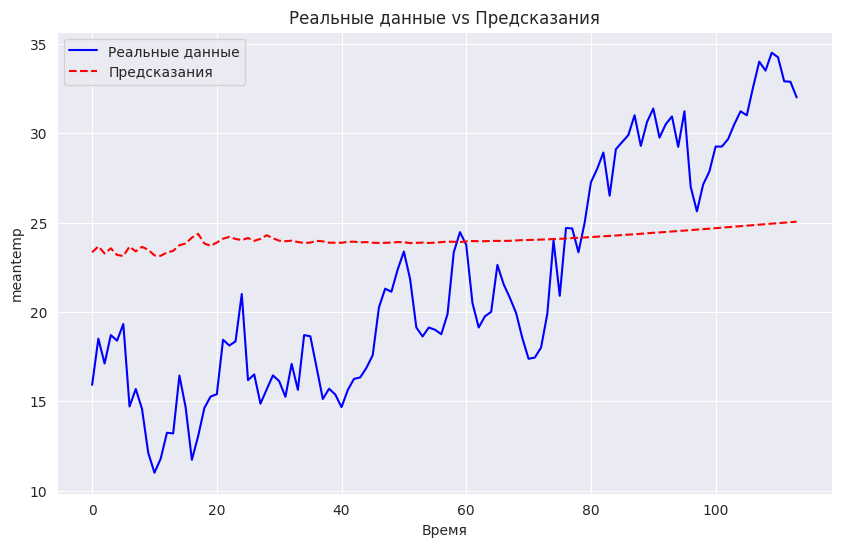

In [10]:
import pandas as pd
import numpy as np
from statsmodels.tsa.api import VAR
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt

# Функция для подбора оптимального количества лагов
def find_optimal_lags(train_X, val_X, val_y):
    best_mae = float('inf')
    best_lag = 1
    for lag in range(1, 30):  # Пробуем лаги от 1 до 10
        model = VAR(train_X)
        results = model.fit(lag)
        forecast = results.forecast(train_X.values[-lag:], steps=len(val_X))
        mae = mean_absolute_error(val_y, forecast[:, 0])  # Предсказываем первый столбец (meantemp)
        if mae < best_mae:
            best_mae = mae
            best_lag = lag
    return best_lag

# Подбор оптимального количества лагов
optimal_lag = find_optimal_lags(train_X_scaled, val_X_scaled, val_y_scaled)
print(f"Оптимальное количество лагов: {optimal_lag}")

# Обучение модели с оптимальным количеством лагов
model = VAR(train_X_scaled)
results = model.fit(optimal_lag)

# Диагностика  остатков
residuals = results.resid.values.flatten()  # Преобразуем в одномерный массив

# Тест Шапиро-Уилка на нормальность остатков
shapiro_test = shapiro(residuals)
print(f"Shapiro-Wilk test: p-value = {shapiro_test.pvalue}")

# Предсказание на тестовой выборке
forecast = results.forecast(train_X_scaled.values[-optimal_lag:], steps=len(test_X_scaled))

# Денормализация предсказаний
forecast_denorm = scaler_y.inverse_transform(forecast[:, 0].reshape(-1, 1)).flatten()

# Денормализация реальных значений
test_y_denorm = scaler_y.inverse_transform(test_y_scaled.reshape(-1, 1)).flatten()

# Вычисление MAE на тестовой выборке
mae = mean_absolute_error(test_y_denorm, forecast_denorm)
print(f"MAE на тестовой выборке: {mae}")

# Построение графика реальных данных и предсказаний
plt.figure(figsize=(10, 6))
plt.plot(test_y_denorm, label='Реальные данные', color='blue')
plt.plot(forecast_denorm, label='Предсказания', color='red', linestyle='--')
plt.title('Реальные данные vs Предсказания')
plt.xlabel('Время')
plt.ylabel('meantemp')
plt.legend()
plt.show()

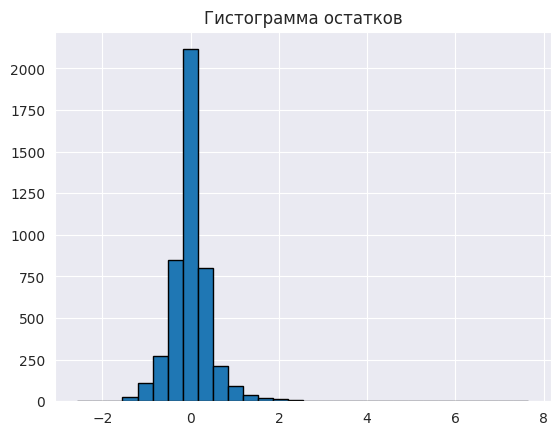

In [11]:
import matplotlib.pyplot as plt
import scipy.stats as stats

# Гистограмма остатков
plt.hist(residuals, bins=30, edgecolor='black')
plt.title('Гистограмма остатков')
plt.show()

SARIMAX

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


MAE на тестовой выборке: 1.8510120368674914e-05


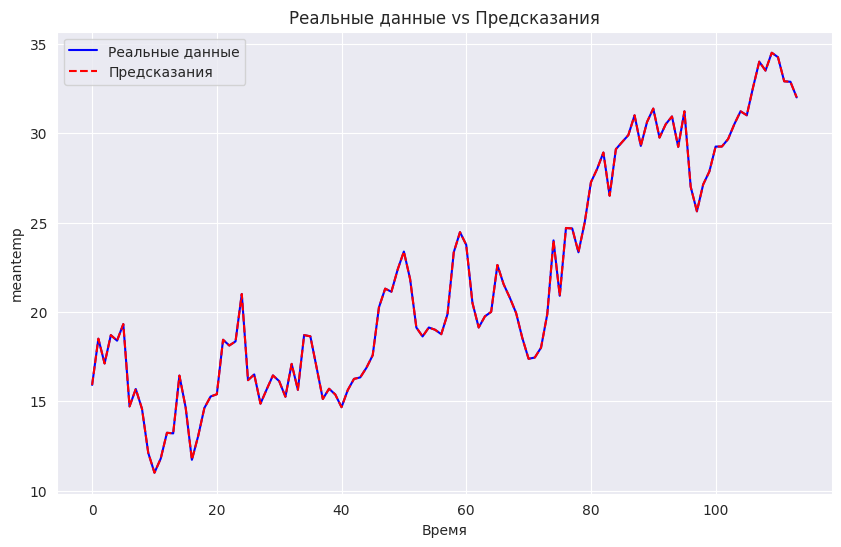

Shapiro-Wilk test: p-value = 3.161361109540996e-29


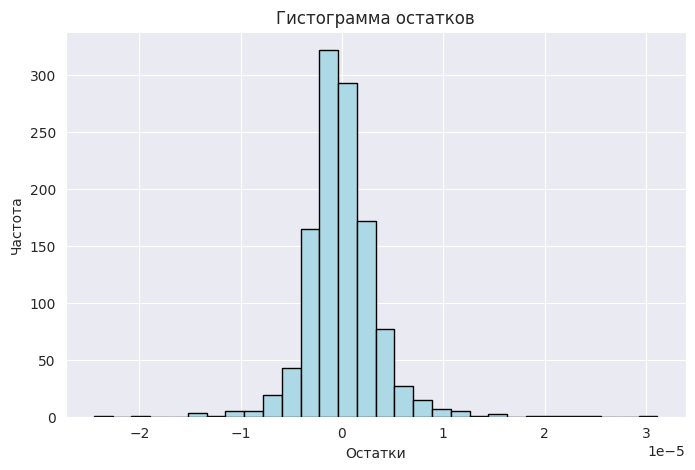

In [13]:
import pandas as pd
import numpy as np
from pmdarima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error
from scipy.stats import shapiro
import matplotlib.pyplot as plt


# Обучение модели с подобранными параметрами
model = SARIMAX(endog=train_y_scaled, exog=train_X_scaled,
                order=(5, 1, 5),
                seasonal_order=(0, 0, 0, 365))
results = model.fit(disp=False)

# Предсказание на тестовой выборке
forecast = results.get_forecast(steps=len(test_X_scaled), exog=test_X_scaled)
forecast_mean = forecast.predicted_mean

# Денормализация предсказаний
forecast_denorm = scaler_y.inverse_transform(forecast_mean.values.reshape(-1, 1)).flatten()

# Денормализация реальных значений
test_y_denorm = scaler_y.inverse_transform(test_y_scaled.reshape(-1, 1)).flatten()

# Вычисление MAE на тестовой выборке
mae = mean_absolute_error(test_y_denorm, forecast_denorm)
print(f"MAE на тестовой выборке: {mae}")

# Построение графика реальных данных и предсказаний
plt.figure(figsize=(10, 6))
plt.plot(test_y_denorm, label='Реальные данные', color='blue')
plt.plot(forecast_denorm, label='Предсказания', color='red', linestyle='--')
plt.title('Реальные данные vs Предсказания')
plt.xlabel('Время')
plt.ylabel('meantemp')
plt.legend()
plt.show()

# Анализ остатков
residuals = results.resid  # Остатки модели

# Тест Шапиро-Уилка на нормальность остатков
shapiro_test = shapiro(residuals)
print(f"Shapiro-Wilk test: p-value = {shapiro_test.pvalue}")

# Гистограмма остатков
plt.figure(figsize=(8, 5))
plt.hist(residuals, bins=30, edgecolor='black', color='lightblue')
plt.title('Гистограмма остатков')
plt.xlabel('Остатки')
plt.ylabel('Частота')
plt.show()

In [25]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt

# Обучение модели XGBoost
model = xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)
model.fit(train_X_scaled, train_y_scaled)

# Предсказание на валидационной выборке
val_forecast = model.predict(val_X_scaled)

# Денормализация предсказаний на валидационной выборке
val_forecast_denorm = scaler_y.inverse_transform(val_forecast.reshape(-1, 1)).flatten()

# Денормализация реальных значений на валидационной выборке
val_y_denorm = scaler_y.inverse_transform(val_y_scaled.reshape(-1, 1)).flatten()

# Вычисление MAE на валидационной выборке
val_mae = mean_absolute_error(val_y_denorm, val_forecast_denorm)
print(f"MAE на валидационной выборке: {val_mae}")

MAE на валидационной выборке: 0.05540110417520233


Boosting

MAE на тестовой выборке: 0.04893978290604733


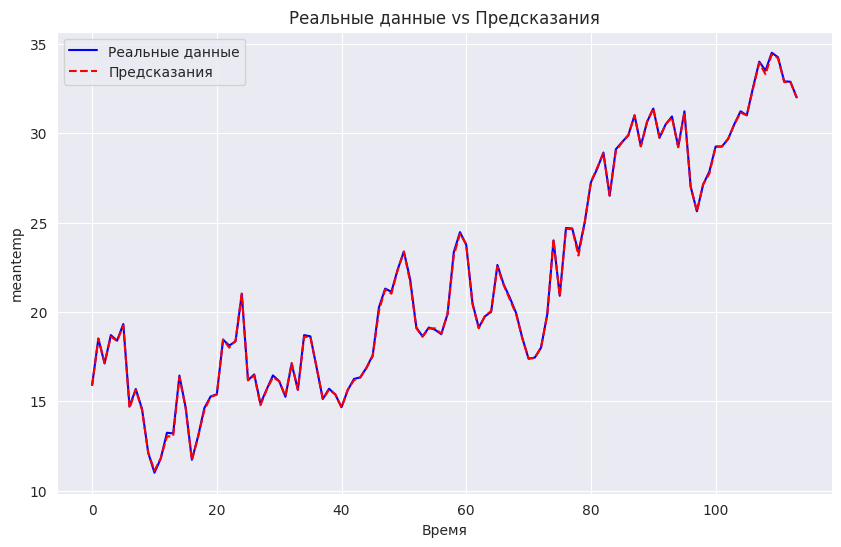

In [26]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt

# Обучение модели XGBoost
model = xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)
model.fit(train_X_scaled, train_y_scaled)

# Предсказание на тестовой выборке
forecast = model.predict(test_X_scaled)

# Денормализация предсказаний
forecast_denorm = scaler_y.inverse_transform(forecast.reshape(-1, 1)).flatten()

# Денормализация реальных значений
test_y_denorm = scaler_y.inverse_transform(test_y_scaled.reshape(-1, 1)).flatten()

# Вычисление MAE на тестовой выборке
mae = mean_absolute_error(test_y_denorm, forecast_denorm)
print(f"MAE на тестовой выборке: {mae}")

# Построение графика реальных данных и предсказаний
plt.figure(figsize=(10, 6))
plt.plot(test_y_denorm, label='Реальные данные', color='blue')
plt.plot(forecast_denorm, label='Предсказания', color='red', linestyle='--')
plt.title('Реальные данные vs Предсказания')
plt.xlabel('Время')
plt.ylabel('meantemp')
plt.legend()
plt.show()

Shapiro-Wilk test: p-value = 0.0007369117926899693


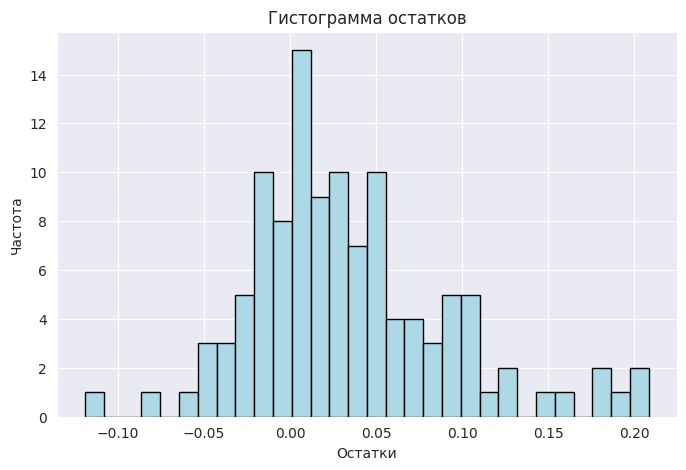

In [27]:
# Анализ остатков
residuals = test_y_denorm - forecast_denorm  # Вычисление остатков

# Тест Шапиро-Уилка на нормальность остатков
shapiro_test = shapiro(residuals)
print(f"Shapiro-Wilk test: p-value = {shapiro_test.pvalue}")

# Гистограмма остатков
plt.figure(figsize=(8, 5))
plt.hist(residuals, bins=30, edgecolor='black', color='lightblue')
plt.title('Гистограмма остатков')
plt.xlabel('Остатки')
plt.ylabel('Частота')
plt.show()


LSTM

Epoch [10/200], Loss: 0.9991
Epoch [20/200], Loss: 0.9932
Epoch [30/200], Loss: 0.9676
Epoch [40/200], Loss: 0.8678
Epoch [50/200], Loss: 0.5754
Epoch [60/200], Loss: 0.2469
Epoch [70/200], Loss: 0.1505
Epoch [80/200], Loss: 0.0759
Epoch [90/200], Loss: 0.0532
Epoch [100/200], Loss: 0.0447
Epoch [110/200], Loss: 0.0397
Epoch [120/200], Loss: 0.0352
Epoch [130/200], Loss: 0.0315
Epoch [140/200], Loss: 0.0282
Epoch [150/200], Loss: 0.0251
Epoch [160/200], Loss: 0.0221
Epoch [170/200], Loss: 0.0193
Epoch [180/200], Loss: 0.0167
Epoch [190/200], Loss: 0.0143
Epoch [200/200], Loss: 0.0121
MAE на тестовой выборке: 0.9080877747889035


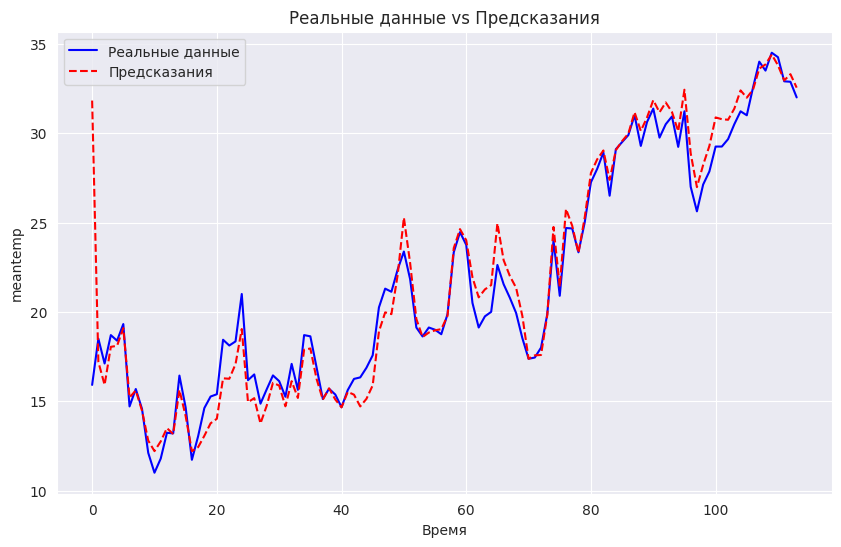

Shapiro-Wilk test: p-value = 5.11626647896901e-17


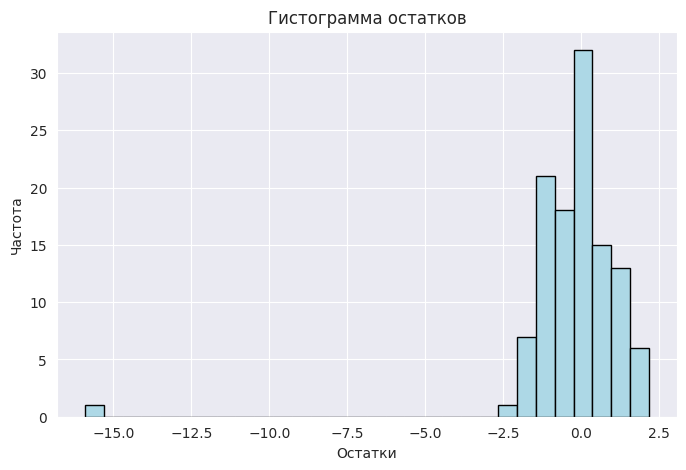

In [48]:
import torch
import torch.nn as nn
import numpy as np
from sklearn.metrics import mean_absolute_error
from scipy.stats import shapiro
import matplotlib.pyplot as plt

# Преобразуем данные в тензоры PyTorch с добавлением фиктивной размерности sequence_length
train_X_tensor = torch.tensor(train_X_scaled.values, dtype=torch.float32).unsqueeze(1)  # Добавляем размерность sequence_length
train_y_tensor = torch.tensor(train_y_scaled, dtype=torch.float32)

val_X_tensor = torch.tensor(val_X_scaled.values, dtype=torch.float32).unsqueeze(1)  # Добавляем размерность sequence_length
val_y_tensor = torch.tensor(val_y_scaled, dtype=torch.float32)

test_X_tensor = torch.tensor(test_X_scaled.values, dtype=torch.float32).unsqueeze(1)  # Добавляем размерность sequence_length
test_y_tensor = torch.tensor(test_y_scaled, dtype=torch.float32)

# Определяем модель LSTM
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])  # Используем только последний выход LSTM
        return out

# Параметры модели
input_size = train_X_scaled.shape[1]  # Количество признаков
hidden_size = 50
num_layers = 4
output_size = 1

# Инициализация модели
model = LSTMModel(input_size, hidden_size, num_layers, output_size)

# Определяем функцию потерь и оптимизатор
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Обучение модели
num_epochs = 200
for epoch in range(num_epochs):
    model.train()
    outputs = model(train_X_tensor)
    optimizer.zero_grad()
    loss = criterion(outputs.squeeze(), train_y_tensor)
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')

# Предсказание на тестовой выборке
model.eval()
with torch.no_grad():
    test_outputs = model(test_X_tensor)

# Денормализация предсказаний
forecast_denorm = scaler_y.inverse_transform(test_outputs.numpy()).flatten()

# Денормализация реальных значений
test_y_denorm = scaler_y.inverse_transform(test_y_scaled.reshape(-1, 1)).flatten()

# Вычисление MAE на тестовой выборке
mae = mean_absolute_error(test_y_denorm, forecast_denorm)
print(f"MAE на тестовой выборке: {mae}")

# Построение графика реальных данных и предсказаний
plt.figure(figsize=(10, 6))
plt.plot(test_y_denorm, label='Реальные данные', color='blue')
plt.plot(forecast_denorm, label='Предсказания', color='red', linestyle='--')
plt.title('Реальные данные vs Предсказания')
plt.xlabel('Время')
plt.ylabel('meantemp')
plt.legend()
plt.show()

# Анализ остатков
residuals = test_y_denorm - forecast_denorm  # Вычисление остатков

# Тест Шапиро-Уилка на нормальность остатков
shapiro_test = shapiro(residuals)
print(f"Shapiro-Wilk test: p-value = {shapiro_test.pvalue}")

# Гистограмма остатков
plt.figure(figsize=(8, 5))
plt.hist(residuals, bins=30, edgecolor='black', color='lightblue')
plt.title('Гистограмма остатков')
plt.xlabel('Остатки')
plt.ylabel('Частота')
plt.show()

In [49]:
train_X_tensor.shape

torch.Size([1169, 1, 4])

Epoch [10/200], Train Loss: 0.9702, Val Loss: 0.9509
Epoch [20/200], Train Loss: 0.8578, Val Loss: 0.7384
Epoch [30/200], Train Loss: 0.3289, Val Loss: 0.1697
Epoch [40/200], Train Loss: 0.2076, Val Loss: 0.1976
Epoch [50/200], Train Loss: 0.1277, Val Loss: 0.1243
Epoch [60/200], Train Loss: 0.1226, Val Loss: 0.1425
Epoch [70/200], Train Loss: 0.1120, Val Loss: 0.1111
Epoch [80/200], Train Loss: 0.1053, Val Loss: 0.1094
Epoch [90/200], Train Loss: 0.0993, Val Loss: 0.1038
Epoch [100/200], Train Loss: 0.0949, Val Loss: 0.1002
Epoch [110/200], Train Loss: 0.0915, Val Loss: 0.0994
Epoch [120/200], Train Loss: 0.0886, Val Loss: 0.0952
Epoch [130/200], Train Loss: 0.0862, Val Loss: 0.0917
Epoch [140/200], Train Loss: 0.0840, Val Loss: 0.0891
Epoch [150/200], Train Loss: 0.0820, Val Loss: 0.0866
Epoch [160/200], Train Loss: 0.0801, Val Loss: 0.0842
Epoch [170/200], Train Loss: 0.0783, Val Loss: 0.0819
Epoch [180/200], Train Loss: 0.0765, Val Loss: 0.0799
Epoch [190/200], Train Loss: 0.0746, 

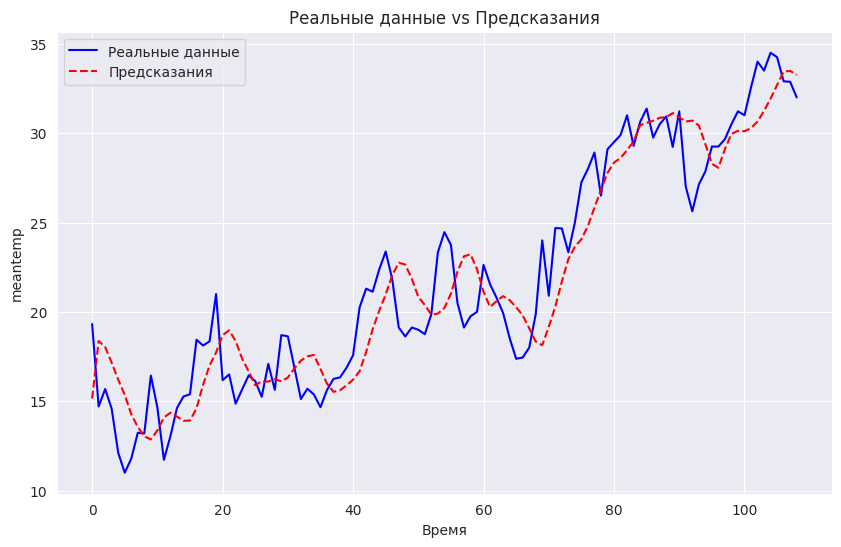

Shapiro-Wilk test: p-value = 0.28324806044979


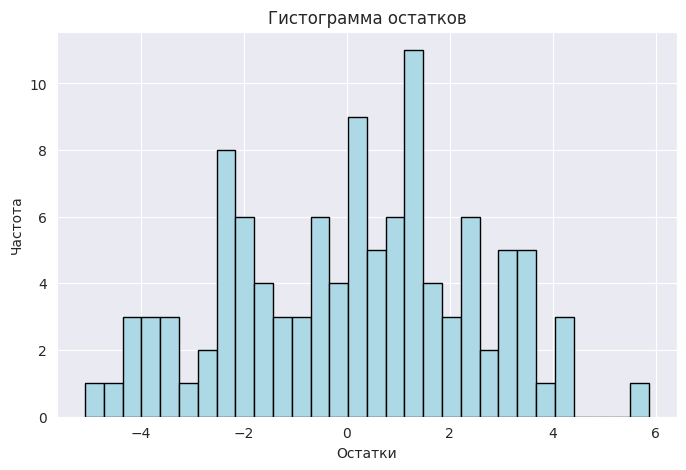

In [51]:
import torch
import torch.nn as nn
import numpy as np
from sklearn.metrics import mean_absolute_error
from scipy.stats import shapiro
import matplotlib.pyplot as plt

# Создаем последовательности длиной 5
sequence_length = 5

# Функция для создания последовательностей
def create_sequences(X, y, sequence_length):
    X_sequences = []
    y_sequences = []
    for i in range(len(X) - sequence_length):
        X_sequences.append(X[i:i + sequence_length])
        y_sequences.append(y[i + sequence_length])
    return np.array(X_sequences), np.array(y_sequences)

# Создаем последовательности для train, val и test
train_X_sequences, train_y_sequences = create_sequences(train_X_scaled, train_y_scaled, sequence_length)
val_X_sequences, val_y_sequences = create_sequences(val_X_scaled, val_y_scaled, sequence_length)
test_X_sequences, test_y_sequences = create_sequences(test_X_scaled, test_y_scaled, sequence_length)

# Преобразуем данные в тензоры PyTorch
train_X_tensor = torch.tensor(train_X_sequences, dtype=torch.float32)
train_y_tensor = torch.tensor(train_y_sequences, dtype=torch.float32)

val_X_tensor = torch.tensor(val_X_sequences, dtype=torch.float32)
val_y_tensor = torch.tensor(val_y_sequences, dtype=torch.float32)

test_X_tensor = torch.tensor(test_X_sequences, dtype=torch.float32)
test_y_tensor = torch.tensor(test_y_sequences, dtype=torch.float32)

# Определяем модель LSTM
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])  # Используем только последний выход LSTM
        return out

# Параметры модели
input_size = train_X_scaled.shape[1]  # Количество признаков
hidden_size = 50
num_layers = 4
output_size = 1

# Инициализация модели
model = LSTMModel(input_size, hidden_size, num_layers, output_size)

# Определяем функцию потерь и оптимизатор
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Переменные для отслеживания лучшей модели
best_val_loss = float('inf')
best_model_state = None

# Обучение модели
num_epochs = 200
for epoch in range(num_epochs):
    model.train()
    outputs = model(train_X_tensor)
    optimizer.zero_grad()
    loss = criterion(outputs.squeeze(), train_y_tensor)
    loss.backward()
    optimizer.step()

    # Валидация
    model.eval()
    with torch.no_grad():
        val_outputs = model(val_X_tensor)
        val_loss = criterion(val_outputs.squeeze(), val_y_tensor)

    # Сохраняем лучшую модель
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_state = model.state_dict()

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}')

# Загружаем лучшую модель
model.load_state_dict(best_model_state)

# Предсказание на тестовой выборке
model.eval()
with torch.no_grad():
    test_outputs = model(test_X_tensor)

# Денормализация предсказаний
forecast_denorm = scaler_y.inverse_transform(test_outputs.numpy()).flatten()

# Денормализация реальных значений
test_y_denorm = scaler_y.inverse_transform(test_y_scaled[sequence_length:].reshape(-1, 1)).flatten()

# Вычисление MAE на тестовой выборке
mae = mean_absolute_error(test_y_denorm, forecast_denorm)
print(f"MAE на тестовой выборке: {mae}")

# Построение графика реальных данных и предсказаний
plt.figure(figsize=(10, 6))
plt.plot(test_y_denorm, label='Реальные данные', color='blue')
plt.plot(forecast_denorm, label='Предсказания', color='red', linestyle='--')
plt.title('Реальные данные vs Предсказания')
plt.xlabel('Время')
plt.ylabel('meantemp')
plt.legend()
plt.show()

# Анализ остатков
residuals = test_y_denorm - forecast_denorm  # Вычисление остатков

# Тест Шапиро-Уилка на нормальность остатков
shapiro_test = shapiro(residuals)
print(f"Shapiro-Wilk test: p-value = {shapiro_test.pvalue}")

# Гистограмма остатков
plt.figure(figsize=(8, 5))
plt.hist(residuals, bins=30, edgecolor='black', color='lightblue')
plt.title('Гистограмма остатков')
plt.xlabel('Остатки')
plt.ylabel('Частота')
plt.show()

Epoch [10/200], Train Loss: 0.9112, Val Loss: 0.9191
Epoch [20/200], Train Loss: 0.3429, Val Loss: 0.3422
Epoch [30/200], Train Loss: 0.2018, Val Loss: 0.1776
Epoch [40/200], Train Loss: 0.1298, Val Loss: 0.1932
Epoch [50/200], Train Loss: 0.1213, Val Loss: 0.1547
Epoch [60/200], Train Loss: 0.1141, Val Loss: 0.1164
Epoch [70/200], Train Loss: 0.1064, Val Loss: 0.1208
Epoch [80/200], Train Loss: 0.1014, Val Loss: 0.1129
Epoch [90/200], Train Loss: 0.0977, Val Loss: 0.1100
Epoch [100/200], Train Loss: 0.0947, Val Loss: 0.1065
Epoch [110/200], Train Loss: 0.0921, Val Loss: 0.1026
Epoch [120/200], Train Loss: 0.0901, Val Loss: 0.0999
Epoch [130/200], Train Loss: 0.0884, Val Loss: 0.0977
Epoch [140/200], Train Loss: 0.0870, Val Loss: 0.0950
Epoch [150/200], Train Loss: 0.0857, Val Loss: 0.0932
Epoch [160/200], Train Loss: 0.0842, Val Loss: 0.0915
Epoch [170/200], Train Loss: 0.0826, Val Loss: 0.0900
Epoch [180/200], Train Loss: 0.0808, Val Loss: 0.0882
Epoch [190/200], Train Loss: 0.0788, 

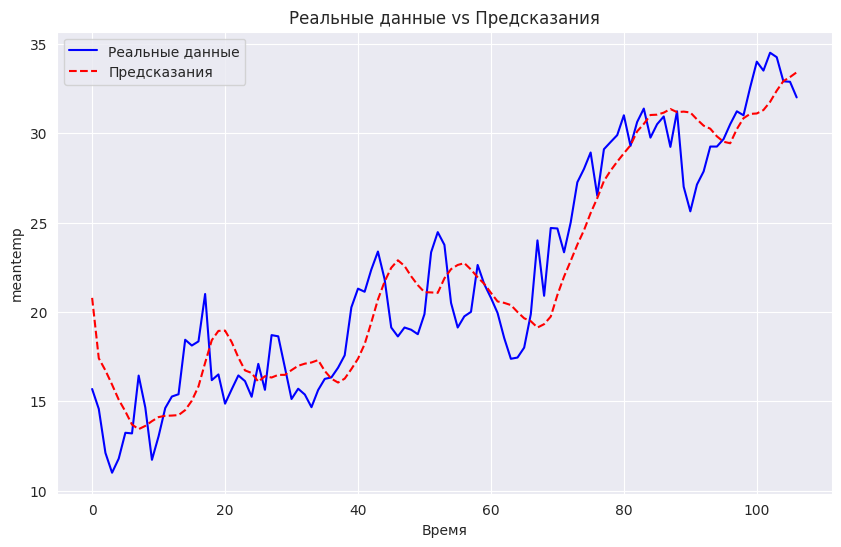

Shapiro-Wilk test: p-value = 0.3065679271433822


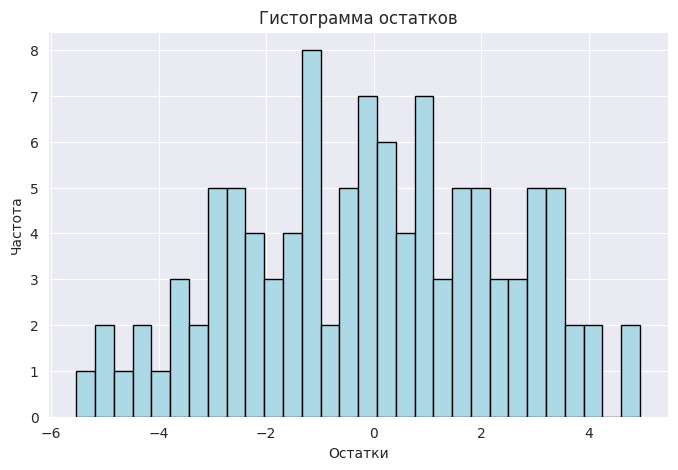

In [52]:
import torch
import torch.nn as nn
import numpy as np
from sklearn.metrics import mean_absolute_error
from scipy.stats import shapiro
import matplotlib.pyplot as plt

# Создаем последовательности длиной 7
sequence_length = 7

# Функция для создания последовательностей
def create_sequences(X, y, sequence_length):
    X_sequences = []
    y_sequences = []
    for i in range(len(X) - sequence_length):
        X_sequences.append(X[i:i + sequence_length])
        y_sequences.append(y[i + sequence_length])
    return np.array(X_sequences), np.array(y_sequences)

# Создаем последовательности для train, val и test
train_X_sequences, train_y_sequences = create_sequences(train_X_scaled, train_y_scaled, sequence_length)
val_X_sequences, val_y_sequences = create_sequences(val_X_scaled, val_y_scaled, sequence_length)
test_X_sequences, test_y_sequences = create_sequences(test_X_scaled, test_y_scaled, sequence_length)

# Преобразуем данные в тензоры PyTorch
train_X_tensor = torch.tensor(train_X_sequences, dtype=torch.float32)
train_y_tensor = torch.tensor(train_y_sequences, dtype=torch.float32)

val_X_tensor = torch.tensor(val_X_sequences, dtype=torch.float32)
val_y_tensor = torch.tensor(val_y_sequences, dtype=torch.float32)

test_X_tensor = torch.tensor(test_X_sequences, dtype=torch.float32)
test_y_tensor = torch.tensor(test_y_sequences, dtype=torch.float32)

# Определяем модель LSTM
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])  # Используем только последний выход LSTM
        return out

# Параметры модели
input_size = train_X_scaled.shape[1]  # Количество признаков
hidden_size = 50
num_layers = 4
output_size = 1

# Инициализация модели
model = LSTMModel(input_size, hidden_size, num_layers, output_size)

# Определяем функцию потерь и оптимизатор
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Переменные для отслеживания лучшей модели
best_val_loss = float('inf')
best_model_state = None

# Обучение модели
num_epochs = 200
for epoch in range(num_epochs):
    model.train()
    outputs = model(train_X_tensor)
    optimizer.zero_grad()
    loss = criterion(outputs.squeeze(), train_y_tensor)
    loss.backward()
    optimizer.step()

    # Валидация
    model.eval()
    with torch.no_grad():
        val_outputs = model(val_X_tensor)
        val_loss = criterion(val_outputs.squeeze(), val_y_tensor)

    # Сохраняем лучшую модель
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_state = model.state_dict()

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}')

# Загружаем лучшую модель
model.load_state_dict(best_model_state)

# Предсказание на тестовой выборке
model.eval()
with torch.no_grad():
    test_outputs = model(test_X_tensor)

# Денормализация предсказаний
forecast_denorm = scaler_y.inverse_transform(test_outputs.numpy()).flatten()

# Денормализация реальных значений
test_y_denorm = scaler_y.inverse_transform(test_y_scaled[sequence_length:].reshape(-1, 1)).flatten()

# Вычисление MAE на тестовой выборке
mae = mean_absolute_error(test_y_denorm, forecast_denorm)
print(f"MAE на тестовой выборке: {mae}")

# Построение графика реальных данных и предсказаний
plt.figure(figsize=(10, 6))
plt.plot(test_y_denorm, label='Реальные данные', color='blue')
plt.plot(forecast_denorm, label='Предсказания', color='red', linestyle='--')
plt.title('Реальные данные vs Предсказания')
plt.xlabel('Время')
plt.ylabel('meantemp')
plt.legend()
plt.show()

# Анализ остатков
residuals = test_y_denorm - forecast_denorm  # Вычисление остатков

# Тест Шапиро-Уилка на нормальность остатков
shapiro_test = shapiro(residuals)
print(f"Shapiro-Wilk test: p-value = {shapiro_test.pvalue}")

# Гистограмма остатков
plt.figure(figsize=(8, 5))
plt.hist(residuals, bins=30, edgecolor='black', color='lightblue')
plt.title('Гистограмма остатков')
plt.xlabel('Остатки')
plt.ylabel('Частота')
plt.show()

CNN

Epoch [10/400], Train Loss: 0.7942, Val Loss: 0.7530
Epoch [20/400], Train Loss: 0.5967, Val Loss: 0.5360
Epoch [30/400], Train Loss: 0.4062, Val Loss: 0.3371
Epoch [40/400], Train Loss: 0.3109, Val Loss: 0.2235
Epoch [50/400], Train Loss: 0.2654, Val Loss: 0.1885
Epoch [60/400], Train Loss: 0.2311, Val Loss: 0.1847
Epoch [70/400], Train Loss: 0.2060, Val Loss: 0.1727
Epoch [80/400], Train Loss: 0.1851, Val Loss: 0.1623
Epoch [90/400], Train Loss: 0.1683, Val Loss: 0.1582
Epoch [100/400], Train Loss: 0.1551, Val Loss: 0.1532
Epoch [110/400], Train Loss: 0.1447, Val Loss: 0.1493
Epoch [120/400], Train Loss: 0.1359, Val Loss: 0.1450
Epoch [130/400], Train Loss: 0.1282, Val Loss: 0.1413
Epoch [140/400], Train Loss: 0.1211, Val Loss: 0.1380
Epoch [150/400], Train Loss: 0.1148, Val Loss: 0.1336
Epoch [160/400], Train Loss: 0.1091, Val Loss: 0.1317
Epoch [170/400], Train Loss: 0.1038, Val Loss: 0.1297
Epoch [180/400], Train Loss: 0.0989, Val Loss: 0.1272
Epoch [190/400], Train Loss: 0.0942, 

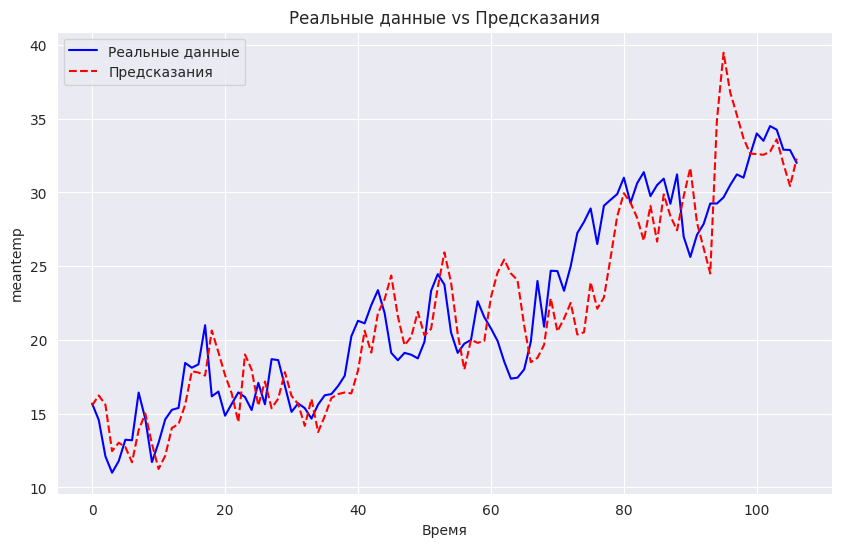

Shapiro-Wilk test: p-value = 0.06438741508855446


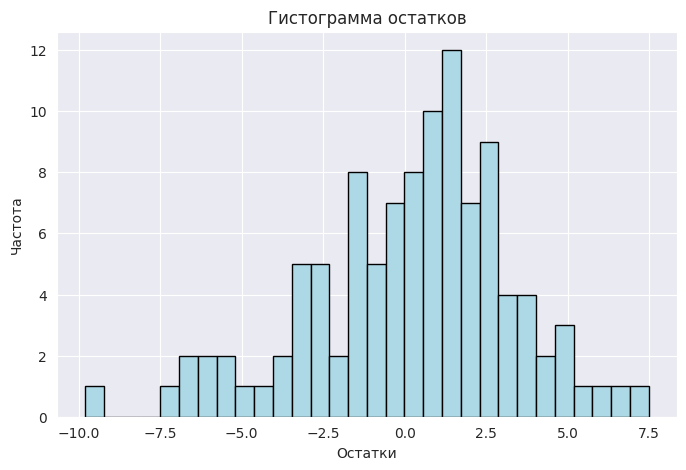

In [73]:
import torch
import torch.nn as nn
import numpy as np
from sklearn.metrics import mean_absolute_error
from scipy.stats import shapiro
import matplotlib.pyplot as plt

# Создаем последовательности длиной sequence_length
sequence_length = 7

# Функция для создания последовательностей
def create_sequences(X, y, sequence_length):
    X_sequences = []
    y_sequences = []
    for i in range(len(X) - sequence_length):
        X_sequences.append(X[i:i + sequence_length])
        y_sequences.append(y[i + sequence_length])
    return np.array(X_sequences), np.array(y_sequences)

# Создаем последовательности для train, val и test
train_X_sequences, train_y_sequences = create_sequences(train_X_scaled, train_y_scaled, sequence_length)
val_X_sequences, val_y_sequences = create_sequences(val_X_scaled, val_y_scaled, sequence_length)
test_X_sequences, test_y_sequences = create_sequences(test_X_scaled, test_y_scaled, sequence_length)

# Преобразуем данные в тензоры PyTorch
train_X_tensor = torch.tensor(train_X_sequences, dtype=torch.float32)
train_y_tensor = torch.tensor(train_y_sequences, dtype=torch.float32)

val_X_tensor = torch.tensor(val_X_sequences, dtype=torch.float32)
val_y_tensor = torch.tensor(val_y_sequences, dtype=torch.float32)

test_X_tensor = torch.tensor(test_X_sequences, dtype=torch.float32)
test_y_tensor = torch.tensor(test_y_sequences, dtype=torch.float32)

# Определяем модель CNN
class CNNModel(nn.Module):
    def __init__(self, input_size, sequence_length, num_filters, kernel_size, hidden_size, output_size):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=sequence_length, out_channels=num_filters, kernel_size=kernel_size)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool1d(kernel_size=2)
        self.fc1 = nn.Linear(num_filters * ((input_size - kernel_size + 1) // 2), hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):

        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

# Параметры модели
input_size = train_X_scaled.shape[1]  # Количество признаков
num_filters = 64
kernel_size = 2
hidden_size = 50
output_size = 1

# Инициализация модели
model = CNNModel(input_size, sequence_length, num_filters, kernel_size, hidden_size, output_size)

# Определяем функцию потерь и оптимизатор
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Переменные для отслеживания лучшей модели
best_val_loss = float('inf')
best_model_state = None

# Обучение модели
num_epochs = 400
for epoch in range(num_epochs):
    model.train()
    outputs = model(train_X_tensor)
    optimizer.zero_grad()
    loss = criterion(outputs.squeeze(), train_y_tensor)
    loss.backward()
    optimizer.step()

    # Валидация
    model.eval()
    with torch.no_grad():
        val_outputs = model(val_X_tensor)
        val_loss = criterion(val_outputs.squeeze(), val_y_tensor)

    # Сохраняем лучшую модель
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_state = model.state_dict()

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}')

# Загружаем лучшую модель
model.load_state_dict(best_model_state)

# Предсказание на тестовой выборке
model.eval()
with torch.no_grad():
    test_outputs = model(test_X_tensor)

# Денормализация предсказаний
forecast_denorm = scaler_y.inverse_transform(test_outputs.numpy()).flatten()

# Денормализация реальных значений
test_y_denorm = scaler_y.inverse_transform(test_y_scaled[sequence_length:].reshape(-1, 1)).flatten()

# Вычисление MAE на тестовой выборке
mae = mean_absolute_error(test_y_denorm, forecast_denorm)
print(f"MAE на тестовой выборке: {mae}")

# Построение графика реальных данных и предсказаний
plt.figure(figsize=(10, 6))
plt.plot(test_y_denorm, label='Реальные данные', color='blue')
plt.plot(forecast_denorm, label='Предсказания', color='red', linestyle='--')
plt.title('Реальные данные vs Предсказания')
plt.xlabel('Время')
plt.ylabel('meantemp')
plt.legend()
plt.show()

# Анализ остатков
residuals = test_y_denorm - forecast_denorm  # Вычисление остатков

# Тест Шапиро-Уилка на нормальность остатков
shapiro_test = shapiro(residuals)
print(f"Shapiro-Wilk test: p-value = {shapiro_test.pvalue}")

# Гистограмма остатков
plt.figure(figsize=(8, 5))
plt.hist(residuals, bins=30, edgecolor='black', color='lightblue')
plt.title('Гистограмма остатков')
plt.xlabel('Остатки')
plt.ylabel('Частота')
plt.show()

Transformers

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [10/200], Train Loss: 0.2305, Val Loss: 0.1550
Epoch [20/200], Train Loss: 0.1387, Val Loss: 0.1512
Epoch [30/200], Train Loss: 0.1101, Val Loss: 0.0967
Epoch [40/200], Train Loss: 0.0858, Val Loss: 0.1033
Epoch [50/200], Train Loss: 0.0714, Val Loss: 0.1177
Epoch [60/200], Train Loss: 0.0663, Val Loss: 0.1272
Epoch [70/200], Train Loss: 0.0648, Val Loss: 0.1264
Epoch [80/200], Train Loss: 0.0627, Val Loss: 0.1193
Epoch [90/200], Train Loss: 0.0560, Val Loss: 0.1328
Epoch [100/200], Train Loss: 0.0575, Val Loss: 0.1159
Epoch [110/200], Train Loss: 0.0575, Val Loss: 0.1243
Epoch [120/200], Train Loss: 0.0553, Val Loss: 0.1260
Epoch [130/200], Train Loss: 0.0540, Val Loss: 0.1314
Epoch [140/200], Train Loss: 0.0520, Val Loss: 0.1281
Epoch [150/200], Train Loss: 0.0554, Val Loss: 0.1411
Epoch [160/200], Train Loss: 0.0515, Val Loss: 0.1364
Epoch [170/200], Train Loss: 0.0511, Val Loss: 0.1336
Epoch [180/200], Train Loss: 0.0539, Val Loss: 0.1190
Epoch [190/200], Train Loss: 0.0503, 

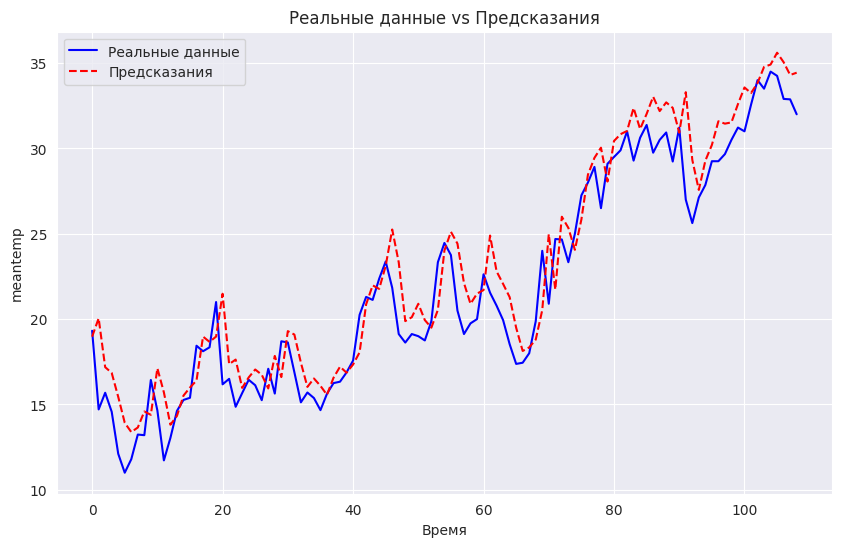

Shapiro-Wilk test: p-value = 0.551541803843004


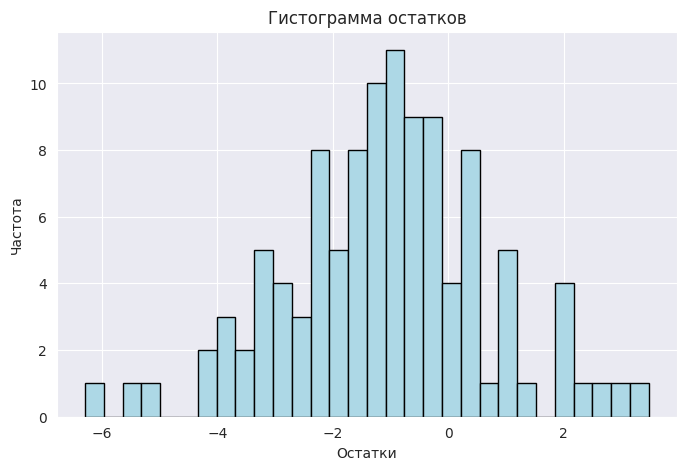

In [74]:
import torch
import torch.nn as nn
import numpy as np
from sklearn.metrics import mean_absolute_error
from scipy.stats import shapiro
import matplotlib.pyplot as plt

# Создаем последовательности длиной sequence_length
sequence_length = 5

# Функция для создания последовательностей
def create_sequences(X, y, sequence_length):
    X_sequences = []
    y_sequences = []
    for i in range(len(X) - sequence_length):
        X_sequences.append(X[i:i + sequence_length])
        y_sequences.append(y[i + sequence_length])
    return np.array(X_sequences), np.array(y_sequences)

# Создаем последовательности для train, val и test
train_X_sequences, train_y_sequences = create_sequences(train_X_scaled, train_y_scaled, sequence_length)
val_X_sequences, val_y_sequences = create_sequences(val_X_scaled, val_y_scaled, sequence_length)
test_X_sequences, test_y_sequences = create_sequences(test_X_scaled, test_y_scaled, sequence_length)

# Преобразуем данные в тензоры PyTorch
train_X_tensor = torch.tensor(train_X_sequences, dtype=torch.float32)
train_y_tensor = torch.tensor(train_y_sequences, dtype=torch.float32)

val_X_tensor = torch.tensor(val_X_sequences, dtype=torch.float32)
val_y_tensor = torch.tensor(val_y_sequences, dtype=torch.float32)

test_X_tensor = torch.tensor(test_X_sequences, dtype=torch.float32)
test_y_tensor = torch.tensor(test_y_sequences, dtype=torch.float32)

# Определяем модель трансформеров
class TransformerModel(nn.Module):
    def __init__(self, input_size, sequence_length, num_heads, hidden_size, num_layers, output_size):
        super(TransformerModel, self).__init__()
        self.embedding = nn.Linear(input_size, hidden_size)  # Встраивание признаков
        self.positional_encoding = nn.Parameter(torch.zeros(1, sequence_length, hidden_size))  # Позиционное кодирование
        self.transformer = nn.Transformer(
            d_model=hidden_size,  # Размерность модели
            nhead=num_heads,  # Количество голов внимания
            num_encoder_layers=num_layers,  # Количество слоев кодировщика
            num_decoder_layers=num_layers,  # Количество слоев декодировщика
            dim_feedforward=hidden_size * 4,  # Размерность полносвязного слоя
            dropout=0.1  # Dropout
        )
        self.fc = nn.Linear(hidden_size, output_size)  # Выходной слой

    def forward(self, x):
        x = self.embedding(x) + self.positional_encoding  # Добавляем позиционное кодирование
        x = self.transformer(x, x)  # Применяем трансформер
        x = self.fc(x[:, -1, :])  # Используем только последний выход
        return x

# Параметры модели
input_size = train_X_scaled.shape[1]  # Количество признаков
num_heads = 4  # Количество голов внимания
hidden_size = 64  # Размерность скрытого слоя
num_layers = 2  # Количество слоев трансформера
output_size = 1  # Количество выходных значений

# Инициализация модели
model = TransformerModel(input_size, sequence_length, num_heads, hidden_size, num_layers, output_size)

# Определяем функцию потерь и оптимизатор
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Переменные для отслеживания лучшей модели
best_val_loss = float('inf')
best_model_state = None

# Обучение модели
num_epochs = 200
for epoch in range(num_epochs):
    model.train()
    outputs = model(train_X_tensor)
    optimizer.zero_grad()
    loss = criterion(outputs.squeeze(), train_y_tensor)
    loss.backward()
    optimizer.step()

    # Валидация
    model.eval()
    with torch.no_grad():
        val_outputs = model(val_X_tensor)
        val_loss = criterion(val_outputs.squeeze(), val_y_tensor)

    # Сохраняем лучшую модель
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_state = model.state_dict()

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}')

# Загружаем лучшую модель
model.load_state_dict(best_model_state)

# Предсказание на тестовой выборке
model.eval()
with torch.no_grad():
    test_outputs = model(test_X_tensor)

# Денормализация предсказаний
forecast_denorm = scaler_y.inverse_transform(test_outputs.numpy()).flatten()

# Денормализация реальных значений
test_y_denorm = scaler_y.inverse_transform(test_y_scaled[sequence_length:].reshape(-1, 1)).flatten()

# Вычисление MAE на тестовой выборке
mae = mean_absolute_error(test_y_denorm, forecast_denorm)
print(f"MAE на тестовой выборке: {mae}")

# Построение графика реальных данных и предсказаний
plt.figure(figsize=(10, 6))
plt.plot(test_y_denorm, label='Реальные данные', color='blue')
plt.plot(forecast_denorm, label='Предсказания', color='red', linestyle='--')
plt.title('Реальные данные vs Предсказания')
plt.xlabel('Время')
plt.ylabel('meantemp')
plt.legend()
plt.show()

# Анализ остатков
residuals = test_y_denorm - forecast_denorm  # Вычисление остатков

# Тест Шапиро-Уилка на нормальность остатков
shapiro_test = shapiro(residuals)
print(f"Shapiro-Wilk test: p-value = {shapiro_test.pvalue}")

# Гистограмма остатков
plt.figure(figsize=(8, 5))
plt.hist(residuals, bins=30, edgecolor='black', color='lightblue')
plt.title('Гистограмма остатков')
plt.xlabel('Остатки')
plt.ylabel('Частота')
plt.show()